In [2]:
import random
seed = 666
random.seed(seed)

import math
import numpy as np
import pandas as pd
import logging
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score 

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
torch.manual_seed(seed)

from point_cloud.utils import preprocess

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu") 
print(device)

cpu


In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 3)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

helpers

In [29]:
def summarize(data):
    print(f'number of trials: {len(data)}')
    
    seq_len = [len(seq) for seq in data]
    print(f'sequence length range: {min(seq_len)} ~ {max(seq_len)}')
    
    ranges = []
    for i in range(4):
        start = min([seq[0, i]  for seq in data])
        end   = max([seq[-1, i] for seq in data])
        ranges.append((start, end))

    print(f'time range (sec): {ranges[0][0]:.3f} ~ {ranges[0][1]:.3f}')
    print(f'x range (um):   {ranges[1][0]:.3f} ~ {ranges[1][1]:.3f}')
    print(f'z range (um):   {ranges[2][0]:.3f} ~ {ranges[2][1]:.3f}')
    print(f'amp range (amp):   {ranges[3][0]:.3f} ~ {ranges[3][1]:.3f}')
    return max(seq_len)

def flatten_auc(xss):
    return [x.cpu().detach().numpy() for xs in xss for x in xs]

def flatten_acc(xss):
    return [x.cpu().detach().numpy().argmax() for xs in xss for x in xs]

def cast(tensor, device):
    return tensor.float().to(device)

def reset_weights(model):
    '''
    resetting model weights to avoid weight leakage.
    '''
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

load data

In [6]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'

In [7]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [8]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [14]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_features = unsorted[:,2:]

In [15]:
spike_sequences = []
for i in range(n_trials):
    # each trial is 1.5 sec long 
    #     (0.5 sec prior to stimulus onset + 1 sec after stimulus onset)
    mask = np.logical_and(spike_times >= stim_on_times[i]-0.5, \
                          spike_times <= stim_on_times[i]+1)
    times_per_trial, features_per_trial = spike_times[mask], spike_features[mask]
    times_per_trial = times_per_trial - times_per_trial.min()
    spike_sequences.append(np.c_[times_per_trial, features_per_trial])

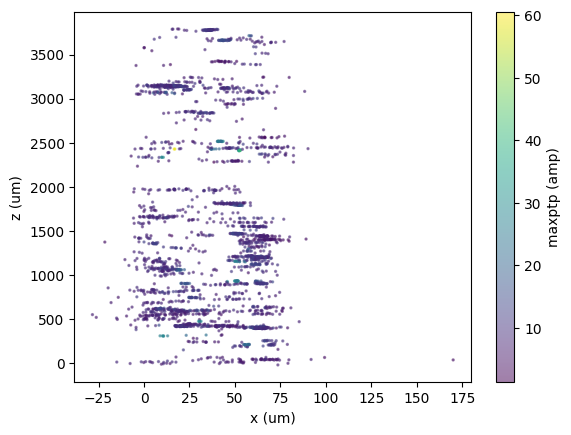

In [24]:
# visualize spike localization features
idx = 10
_, x, z, maxptp = spike_sequences[idx].T
plt.scatter(x, 
            z, 
            c=maxptp, s=2, alpha=0.5),
plt.xlabel('x (um)')
plt.ylabel('z (um)')
plt.colorbar(label='maxptp (amp)');

In [60]:
max_seq_len = summarize(spike_sequences)

number of trials: 265
sequence length range: 2111 ~ 3428
time range (sec): 0.000 ~ 1.500
x range (um):   -20.610 ~ 106.152
z range (um):   41.546 ~ 3768.892
amp range (amp):   2.589 ~ 34.955


permutation invariant neural nets

In [31]:
class Encoder(nn.Module):
    '''

    '''
    def __init__(self, config, device):
        super().__init__()
        self.seq_len = config.seq_len

        encoder_layers = []
        encoder_layers.append(nn.Linear(config.n_feature, config.emb_dim*2, bias=False))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(config.emb_dim*2, config.emb_dim, bias=False))
        self.encoder = nn.Sequential(*encoder_layers)

        self.device = device

    def encode(self, batch_seqs):
        batch_embeds = self.encoder(batch_seqs) 
        return batch_embeds

In [32]:
def time_binning(spike_embeds, spike_times, spike_masks, n_time_bin=30, t_min=0.0, t_max=1.5):
    time_binned_embeds_lst = []
    for i, _ in enumerate(spike_embeds):
        t_bins = torch.arange(t_min, t_max, step=(t_max - t_min)/n_time_bin).to(device)
        masks = [(torch.bucketize(spike_times[i], t_bins, right=True)-1 == idx) for idx in range(n_time_bin)]
        time_binned_embeds = torch.stack([((spike_masks[i] * masks[idx]).repeat(spike_embeds[i].shape[1], 1).transpose(1,0) \
                                           * spike_embeds[i]) for idx in range(n_time_bin)]).sum(1).to(device)
        time_binned_embeds_lst.append(time_binned_embeds)
    return torch.stack(time_binned_embeds_lst)

In [37]:
class EncoderDecoder(nn.Module):
    '''
    
    '''
    def __init__(self, config, device):
        super(EncoderDecoder, self).__init__()
        self.config = config
        self.n_time_bin = config.n_time_bin
        self.emb_dim = config.emb_dim
        self.n_class = config.n_class
        self.device = device
        
        self.enc = Encoder(config, device)
        
        decoder_layers = []
        decoder_layers.append(nn.Flatten(start_dim=1)) 
        decoder_layers.append(nn.BatchNorm1d(self.n_time_bin * self.emb_dim)) # 30 * 32 = 960
        decoder_layers.append(nn.Linear(self.n_time_bin * self.emb_dim, self.n_class))  
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.softmax = nn.Softmax(dim=1)
                
        self.optimizer = self.set_optimizer(config.opt, config.lr)
        self.to(device)

    def loss(self, batch_seqs, batch_ts, batch_masks, batch_labels):
        batch_preds = self(batch_seqs, batch_ts, batch_masks)    
        criterion = nn.CrossEntropyLoss()
        batch_loss = criterion(batch_preds, batch_labels)
        return batch_loss  
    
    def forward(self, batch_seqs, batch_ts, batch_masks):        
        batch_embeds = self.enc.encode(batch_seqs)
        batch_embeds = batch_embeds * batch_masks.unsqueeze(-1).repeat(1, 1, config.emb_dim)
        batch_embeds = time_binning(batch_embeds, batch_ts, batch_masks)
        batch_preds = self.decoder(batch_embeds)
        batch_preds = self.softmax(batch_preds)
        return batch_preds
    
    def set_optimizer(self, opt, lr):
        if opt == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=lr, betas=(0.99, 0.999))

In [38]:
class AverageMeter(object):
    '''
    Computes and stores the average and current value.
    '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    loss_meter = AverageMeter()
    auc_meter = AverageMeter()
    acc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)
        y_true = batch_labels.cpu().detach().numpy()
        y_pred = model(batch_seqs, batch_ts, batch_masks).cpu().detach().numpy()
        loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_labels)
        loss_meter.update(loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        auc_meter.update(auc)
        acc = accuracy_score(y_true.argmax(1), y_pred.argmax(1))
        acc_meter.update(acc)
        
    return loss_meter.avg, auc_meter.avg, acc_meter.avg

In [39]:
def train(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.1)
    best_eval = np.infty
    loss_meter = AverageMeter()

    train_losses = []
    val_losses = []
    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_labels)

            if torch.isnan(loss):
                print('Numerical error, quiting...')
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip)
            model.optimizer.step()

            loss_meter.update(loss.item())

        scheduler.step()

        logger.info('In epochs {} | '
                    'total loss: {:5f}'.format(
            epoch, loss_meter.avg
        ))
        if (epoch+1)%config.eval_epoch==0:
            train_loss, train_auc, train_acc = eval_loss(model, train_loader, device)
            val_loss, val_auc, val_acc = eval_loss(model, val_loader, device)
            logger.info('Val Loss {:5f} Val AUC {:5f} Val Acc {:5f}'.format(val_loss, val_auc, val_acc))
            train_losses.append([[train_loss],[train_auc],[train_acc]])
            val_losses.append([[val_loss],[val_auc],[val_acc]])

    print('Training done!')
    val_losses = np.asarray(val_losses)
    train_losses = np.asarray(train_losses) 
    return train_losses, val_losses

train model

In [61]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(hid_dim=32, emb_dim=32, n_feature=3, n_time_bin=30, n_class = 2,
                   lr=1e-4, epochs=50, batch=32, opt='Adam', 
                   seq_len=max_seq_len, eval_epoch=1,
                   drop_out=0.0, clip=1e7)

In [42]:
logger = logging.getLogger('batch{}'.format(config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('batch{}.log'.format(config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [43]:
class SpatioTemporalDataset(torch.utils.data.Dataset):

    def __init__(self, train_set, test_set, train, train_labels, test_labels):
        self.S_mean, self.S_std = self._standardize(train_set)

        # standardize input data to neural nets
        S_mean_ = torch.cat([torch.zeros(1, 1).to(self.S_mean), self.S_mean], dim=1)
        S_std_ = torch.cat([torch.ones(1, 1).to(self.S_std), self.S_std], dim=1)
        self.dataset = [(torch.tensor(seq) - S_mean_) / S_std_ for seq in (train_set if train else test_set)]
        
        self.labels = [torch.tensor(label) for label in (train_labels if train else test_labels)]

    def __len__(self):
        return len(self.dataset)

    def _standardize(self, dataset):
        dataset = [torch.tensor(seq) for seq in dataset]
        full = torch.cat(dataset, dim=0)
        S = full[:, 1:]
        S_mean = S.mean(0, keepdims=True)
        S_std = S.std(0, keepdims=True)
        return S_mean, S_std

    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]

In [52]:
class NeuralData(SpatioTemporalDataset):
        def __init__(self, split='train', train_ids=None, val_ids=None, test_ids=None):
            assert split in ['train', 'val', 'test']
            self.split = split
            data_splits = {'train': train_ids, 'val': val_ids, 'test': test_ids}
            train_set = [spike_sequences[idx] for idx in train_ids]
            split_set = [spike_sequences[idx] for idx in data_splits[split]]
            train_labels = [choices[idx] for idx in train_ids]
            split_labels = [choices[idx] for idx in data_splits[split]]
            super().__init__(train_set, split_set, split == 'train', train_labels, split_labels)

        def extra_repr(self):
            return f'split: {self.split}'

In [62]:
def spike_sequence_padding(dataset):
    '''
    Input is a list of tensors with shape (T, 1 + D), D is feature dim, 
        where T may be different for each tensor.
    Returns:
        spike_times: (N, max_seq_len)
        features: (N, max_seq_len, D)
        mask: (N, max_seq_len)
    '''
    if len(dataset) == 0:
        return torch.zeros(1, 1), torch.zeros(1, 1, 2), torch.zeros(1, 1)
    seqs = [x[0] for x in dataset]
    labels = [x[1] for x in dataset]
    dim = seqs[0].shape[1]
    lengths = [seq.shape[0] for seq in seqs]
    padded_seqs = [torch.cat([s, torch.zeros(max_seq_len - s.shape[0], dim).to(s)], 0) if s.shape[0] != max_seq_len else s for s in seqs]
    seqs = torch.stack(padded_seqs, dim=0)
    spike_times = seqs[:, :, 0]
    spike_features = seqs[:, :, 1:]
    mask = torch.stack([torch.cat([torch.ones(seq_len), torch.zeros(max_seq_len - seq_len)], dim=0) for seq_len in lengths])
    labels = torch.stack(labels, dim=0)
    return spike_times, spike_features, mask, labels

In [63]:
trial_ids = np.arange(n_trials)
random.shuffle(trial_ids)

In [64]:
train_ids = trial_ids[:212]
val_ids = trial_ids[212:238]
test_ids = trial_ids[238:]

train_set = NeuralData(split='train', train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
val_set = NeuralData(split='val', train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
test_set = NeuralData(split='test', train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)

In [70]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=config.batch,
    shuffle=True,
    collate_fn=spike_sequence_padding,
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=config.batch,
    shuffle=False,
    collate_fn=spike_sequence_padding,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=config.batch,
    shuffle=False,
    collate_fn=spike_sequence_padding,
)

In [71]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [72]:
model = EncoderDecoder(config, device)
model.apply(reset_weights)

Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


EncoderDecoder(
  (enc): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=False)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=False)
    )
  )
  (decoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=960, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [73]:
# prefer small models to prevent over-fitting
sum([param.nelement() for param in model.parameters()])

6082

In [74]:
train_losses, val_losses = train(model, train_loader, val_loader, config, logger, device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:30:39,915 INFO In epochs 0 | total loss: 0.720764
2022-12-04 22:30:43,618 INFO Val Loss 0.717492 Val AUC 0.500000 Val Acc 0.500000


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:30:58,823 INFO In epochs 1 | total loss: 0.703327
2022-12-04 22:31:02,243 INFO Val Loss 0.671679 Val AUC 0.583333 Val Acc 0.692308


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:31:17,343 INFO In epochs 2 | total loss: 0.692343
2022-12-04 22:31:20,786 INFO Val Loss 0.650075 Val AUC 0.658333 Val Acc 0.653846


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:31:36,085 INFO In epochs 3 | total loss: 0.680913
2022-12-04 22:31:39,597 INFO Val Loss 0.638287 Val AUC 0.716667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:31:54,411 INFO In epochs 4 | total loss: 0.670859
2022-12-04 22:31:57,893 INFO Val Loss 0.632272 Val AUC 0.733333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:32:13,274 INFO In epochs 5 | total loss: 0.661812
2022-12-04 22:32:16,821 INFO Val Loss 0.628021 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:32:31,802 INFO In epochs 6 | total loss: 0.653735
2022-12-04 22:32:35,379 INFO Val Loss 0.624158 Val AUC 0.741667 Val Acc 0.692308


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:32:50,506 INFO In epochs 7 | total loss: 0.646394
2022-12-04 22:32:54,044 INFO Val Loss 0.619027 Val AUC 0.733333 Val Acc 0.653846


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:33:09,123 INFO In epochs 8 | total loss: 0.639095
2022-12-04 22:33:12,624 INFO Val Loss 0.617070 Val AUC 0.741667 Val Acc 0.653846


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:33:27,330 INFO In epochs 9 | total loss: 0.632873
2022-12-04 22:33:30,807 INFO Val Loss 0.613041 Val AUC 0.733333 Val Acc 0.692308


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:33:45,752 INFO In epochs 10 | total loss: 0.626794
2022-12-04 22:33:49,248 INFO Val Loss 0.609448 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:34:04,534 INFO In epochs 11 | total loss: 0.620658
2022-12-04 22:34:08,124 INFO Val Loss 0.608057 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:34:23,092 INFO In epochs 12 | total loss: 0.615029
2022-12-04 22:34:26,530 INFO Val Loss 0.603955 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:34:41,416 INFO In epochs 13 | total loss: 0.609734
2022-12-04 22:34:44,866 INFO Val Loss 0.604335 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:34:59,677 INFO In epochs 14 | total loss: 0.605058
2022-12-04 22:35:03,179 INFO Val Loss 0.605517 Val AUC 0.725000 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:35:18,335 INFO In epochs 15 | total loss: 0.600298
2022-12-04 22:35:21,831 INFO Val Loss 0.601794 Val AUC 0.733333 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:35:36,705 INFO In epochs 16 | total loss: 0.596085
2022-12-04 22:35:40,219 INFO Val Loss 0.600995 Val AUC 0.741667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:35:55,057 INFO In epochs 17 | total loss: 0.592094
2022-12-04 22:35:58,528 INFO Val Loss 0.603289 Val AUC 0.741667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:36:13,392 INFO In epochs 18 | total loss: 0.588075
2022-12-04 22:36:16,844 INFO Val Loss 0.597952 Val AUC 0.741667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:36:31,772 INFO In epochs 19 | total loss: 0.584273
2022-12-04 22:36:35,398 INFO Val Loss 0.599769 Val AUC 0.741667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:36:50,168 INFO In epochs 20 | total loss: 0.581154
2022-12-04 22:36:53,584 INFO Val Loss 0.585880 Val AUC 0.750000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:37:08,374 INFO In epochs 21 | total loss: 0.577602
2022-12-04 22:37:11,879 INFO Val Loss 0.586231 Val AUC 0.758333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:37:26,782 INFO In epochs 22 | total loss: 0.574234
2022-12-04 22:37:30,498 INFO Val Loss 0.589649 Val AUC 0.758333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:37:45,384 INFO In epochs 23 | total loss: 0.571091
2022-12-04 22:37:48,966 INFO Val Loss 0.588825 Val AUC 0.766667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:38:03,772 INFO In epochs 24 | total loss: 0.568827
2022-12-04 22:38:07,351 INFO Val Loss 0.595135 Val AUC 0.766667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:38:22,327 INFO In epochs 25 | total loss: 0.565996
2022-12-04 22:38:25,926 INFO Val Loss 0.591387 Val AUC 0.775000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:38:41,158 INFO In epochs 26 | total loss: 0.563414
2022-12-04 22:38:44,731 INFO Val Loss 0.591556 Val AUC 0.766667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:38:59,532 INFO In epochs 27 | total loss: 0.560500
2022-12-04 22:39:03,094 INFO Val Loss 0.587166 Val AUC 0.758333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:39:18,263 INFO In epochs 28 | total loss: 0.557557
2022-12-04 22:39:21,769 INFO Val Loss 0.584198 Val AUC 0.775000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:39:37,138 INFO In epochs 29 | total loss: 0.554834
2022-12-04 22:39:40,716 INFO Val Loss 0.577585 Val AUC 0.775000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:39:55,717 INFO In epochs 30 | total loss: 0.552065
2022-12-04 22:39:59,258 INFO Val Loss 0.575411 Val AUC 0.775000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:40:14,470 INFO In epochs 31 | total loss: 0.549557
2022-12-04 22:40:18,165 INFO Val Loss 0.575794 Val AUC 0.783333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:40:33,669 INFO In epochs 32 | total loss: 0.547304
2022-12-04 22:40:37,198 INFO Val Loss 0.574559 Val AUC 0.783333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:40:52,263 INFO In epochs 33 | total loss: 0.545051
2022-12-04 22:40:55,715 INFO Val Loss 0.571569 Val AUC 0.791667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:41:10,874 INFO In epochs 34 | total loss: 0.542628
2022-12-04 22:41:14,359 INFO Val Loss 0.561943 Val AUC 0.800000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:41:29,688 INFO In epochs 35 | total loss: 0.540321
2022-12-04 22:41:33,216 INFO Val Loss 0.555738 Val AUC 0.791667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:41:48,092 INFO In epochs 36 | total loss: 0.538130
2022-12-04 22:41:51,573 INFO Val Loss 0.559295 Val AUC 0.791667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:42:06,733 INFO In epochs 37 | total loss: 0.536042
2022-12-04 22:42:10,303 INFO Val Loss 0.558914 Val AUC 0.800000 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:42:25,665 INFO In epochs 38 | total loss: 0.534260
2022-12-04 22:42:29,148 INFO Val Loss 0.559714 Val AUC 0.791667 Val Acc 0.730769


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:42:44,098 INFO In epochs 39 | total loss: 0.532339
2022-12-04 22:42:47,690 INFO Val Loss 0.551773 Val AUC 0.791667 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:43:02,723 INFO In epochs 40 | total loss: 0.530485
2022-12-04 22:43:06,624 INFO Val Loss 0.551726 Val AUC 0.808333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:43:21,461 INFO In epochs 41 | total loss: 0.528370
2022-12-04 22:43:24,992 INFO Val Loss 0.546576 Val AUC 0.800000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:43:40,020 INFO In epochs 42 | total loss: 0.526583
2022-12-04 22:43:43,478 INFO Val Loss 0.543047 Val AUC 0.800000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:43:58,729 INFO In epochs 43 | total loss: 0.524731
2022-12-04 22:44:02,255 INFO Val Loss 0.541151 Val AUC 0.800000 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:44:17,874 INFO In epochs 44 | total loss: 0.523061
2022-12-04 22:44:21,423 INFO Val Loss 0.542211 Val AUC 0.808333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:44:36,450 INFO In epochs 45 | total loss: 0.521165
2022-12-04 22:44:39,982 INFO Val Loss 0.537626 Val AUC 0.808333 Val Acc 0.769231


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:44:55,337 INFO In epochs 46 | total loss: 0.519339
2022-12-04 22:44:58,791 INFO Val Loss 0.534651 Val AUC 0.808333 Val Acc 0.807692


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:45:14,892 INFO In epochs 47 | total loss: 0.517662
2022-12-04 22:45:18,676 INFO Val Loss 0.535532 Val AUC 0.808333 Val Acc 0.807692


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:45:33,740 INFO In epochs 48 | total loss: 0.516050
2022-12-04 22:45:37,264 INFO Val Loss 0.528856 Val AUC 0.808333 Val Acc 0.807692


  0%|          | 0/7 [00:00<?, ?it/s]

2022-12-04 22:45:51,985 INFO In epochs 49 | total loss: 0.514338
2022-12-04 22:45:55,561 INFO Val Loss 0.525772 Val AUC 0.800000 Val Acc 0.846154


Training done!


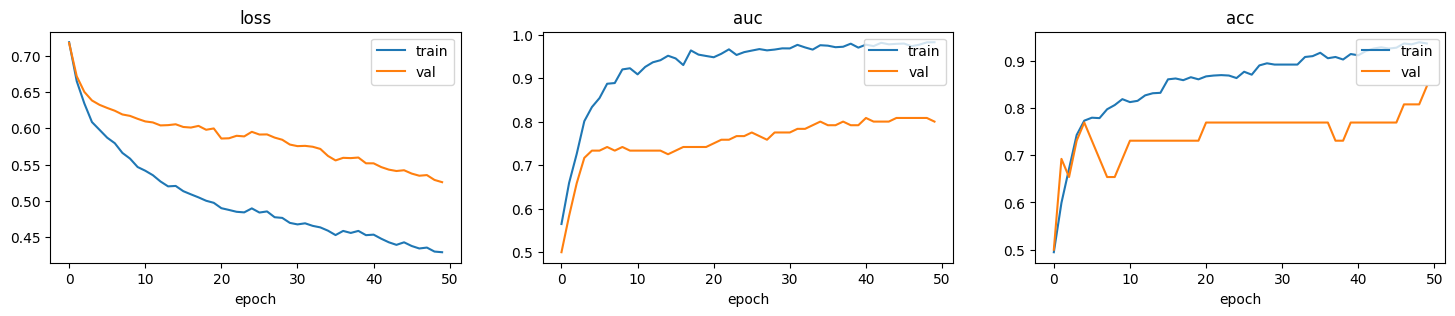

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
axes[0].plot(train_losses[:,0], label='train')
axes[0].plot(val_losses[:,0], label='val')
axes[0].set_xlabel('epoch')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], label='train')
axes[1].plot(val_losses[:,1], label='val')
axes[1].set_xlabel('epoch')
axes[1].set_title('auc')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], label='train')
axes[2].plot(val_losses[:,2], label='val')
axes[2].set_xlabel('epoch')
axes[2].set_title('acc')
axes[2].legend(loc=1);

In [76]:
model.eval()
y_pred_lst = []
y_true_lst = []
for index, batch in enumerate(test_loader):
    batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)
    batch_preds = model(batch_seqs, batch_ts, batch_masks)
    y_pred_lst.append(batch_preds)
    y_true_lst.append(batch_labels);

In [77]:
print('test avg auc: {:.2f}'.format(roc_auc_score(flatten_auc(y_true_lst), flatten_auc(y_pred_lst))))
print('test avg acc: {:.2f}'.format(accuracy_score(flatten_acc(y_true_lst), flatten_acc(y_pred_lst))))

test avg auc: 0.87
test avg acc: 0.89


In [78]:
print(y_pred_lst[0][:5]) # soft classfication results 
print(y_true_lst[0][:5])

tensor([[9.8565e-01, 1.4347e-02],
        [9.9967e-01, 3.3333e-04],
        [1.7539e-02, 9.8246e-01],
        [3.1435e-01, 6.8565e-01],
        [7.8573e-01, 2.1427e-01]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])


visualize spike embeddings and time binned embeddings

In [79]:
data_set = NeuralData(split='train', train_ids=np.arange(n_trials), val_ids=None, test_ids=None)

In [80]:
data_loader = torch.utils.data.DataLoader(
    dataset=data_set,
    batch_size=config.batch,
    shuffle=False,
    collate_fn=spike_sequence_padding
)

In [81]:
model.eval()
all_embeds_lst = []
all_time_binned_embeds_lst = []
for index, batch in enumerate(data_loader):
    batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)
    batch_embeds = model.enc.encode(batch_seqs)
    batch_embeds = batch_embeds * batch_masks.unsqueeze(-1).repeat(1, 1, config.emb_dim)
    time_binned_embeds = time_binning(batch_embeds, batch_ts, batch_masks)
    all_embeds_lst.append(batch_embeds.cpu().detach().numpy())
    all_time_binned_embeds_lst.append(time_binned_embeds.cpu().detach().numpy())

In [82]:
all_embeds = np.vstack(all_embeds_lst)
all_time_binned_embeds = np.vstack(all_time_binned_embeds_lst)

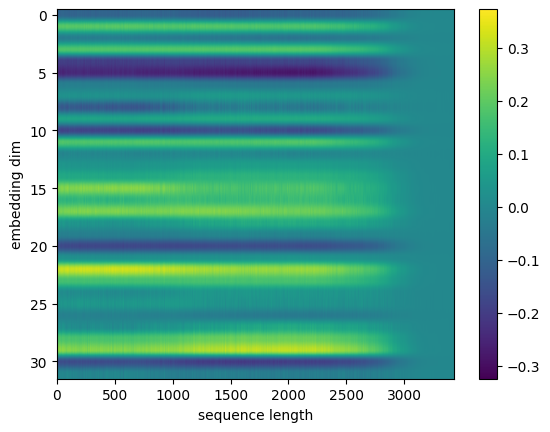

In [83]:
plt.imshow(all_embeds.mean(0).transpose(), aspect='auto');
plt.xlabel('sequence length')
plt.ylabel('embedding dim')
plt.colorbar();

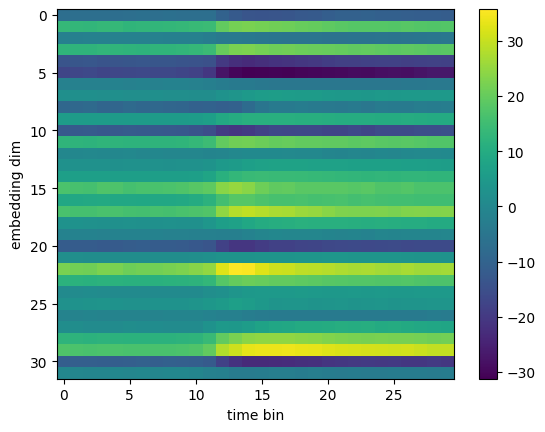

In [84]:
plt.imshow(all_time_binned_embeds.mean(0).transpose(), aspect='auto');
plt.xlabel('time bin')
plt.ylabel('embedding dim')
plt.colorbar();

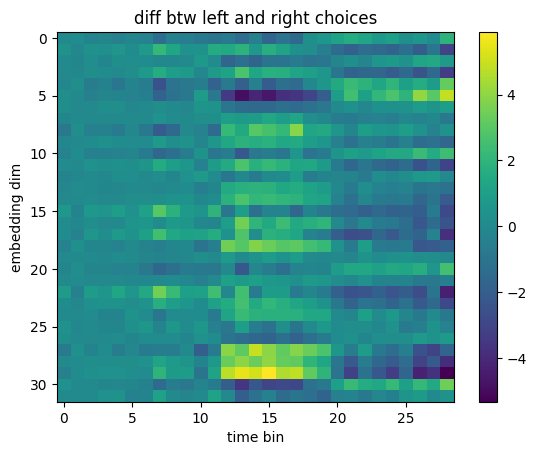

In [85]:
left_trial_heatmap = all_time_binned_embeds[choices.argmax(1) == 0,1:,:].mean(0).transpose()
right_trial_heatmap = all_time_binned_embeds[choices.argmax(1) == 1,1:,:].mean(0).transpose()
diff_trial_heatmap = left_trial_heatmap - right_trial_heatmap

plt.imshow(diff_trial_heatmap, aspect='auto');
plt.xlabel('time bin')
plt.ylabel('embedding dim')
plt.title('diff btw left and right choices')
plt.colorbar();

cross validation

In [91]:
def CV_eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    auc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)
        y_true = batch_labels.cpu().detach().numpy()
        y_pred = model(batch_seqs, batch_ts, batch_masks).cpu().detach().numpy()
        loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_labels)
        loss_meter.update(loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        auc_meter.update(auc)
        acc = accuracy_score(y_true.argmax(1), y_pred.argmax(1))
        acc_meter.update(acc)
        
    return loss_meter.avg, auc_meter.avg, acc_meter.avg

In [92]:
def CV_train(model, train_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.1)
    best_eval = np.infty
    loss_meter = AverageMeter()

    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_ts, batch_seqs, batch_masks, batch_labels = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            loss = model.loss(batch_seqs, batch_ts, batch_masks, batch_labels)

            if torch.isnan(loss):
                print("Numerical error, quiting...")
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip, norm_type=2)
            model.optimizer.step()

            loss_meter.update(loss.item())

        scheduler.step()

        logger.info("In epochs {} | "
                    "total loss: {:5f}".format(
            epoch, loss_meter.avg
        ))

    print("Training done!")
    return model

In [94]:
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

fold = 0
cv_accs = []
cv_aucs = []
for fold, (train_idx, test_idx) in enumerate(kfold.split(spike_seqs, choices.argmax(1))):

    gc.collect()
    torch.cuda.empty_cache()

    print('------------------------------------------------------------------------')
    print(f'training for fold {fold+1} ...')

    train_set = NeuralData(split="train", train_ids=train_idx, val_ids=None, test_ids=test_idx)
    test_set = NeuralData(split="test", train_ids=train_idx, val_ids=None, test_ids=test_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=config.batch,
        shuffle=True,
        collate_fn=spike_sequence_padding,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=config.batch,
        shuffle=False,
        collate_fn=spike_sequence_padding,
    )

    model = EncoderDecoder(config, device)
    model.apply(reset_weights)
    model = CV_train(model, train_loader, config, logger, device)

    _, auc, acc = CV_eval_loss(model, test_loader, device)
    cv_accs.append(acc)
    cv_aucs.append(auc)
    print(f'test accuracy: {acc} auc: {auc}.')

print(f'avg {fold+1}-fold cv accuracy: {np.mean(cv_accs)} auc: {np.mean(cv_aucs)}.')
print(f'sd of {fold+1}-fold cv accuracy: {np.std(cv_accs)} auc: {np.std(cv_aucs)}.')

------------------------------------------------------------------------
training for fold 1 ...
Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:14:52,934 INFO In epochs 0 | total loss: 0.710469
INFO:batch32:In epochs 0 | total loss: 0.710469


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:14:55,588 INFO In epochs 1 | total loss: 0.694381
INFO:batch32:In epochs 1 | total loss: 0.694381


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:14:58,217 INFO In epochs 2 | total loss: 0.683656
INFO:batch32:In epochs 2 | total loss: 0.683656


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:00,856 INFO In epochs 3 | total loss: 0.674875
INFO:batch32:In epochs 3 | total loss: 0.674875


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:03,495 INFO In epochs 4 | total loss: 0.666748
INFO:batch32:In epochs 4 | total loss: 0.666748


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:06,121 INFO In epochs 5 | total loss: 0.658114
INFO:batch32:In epochs 5 | total loss: 0.658114


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:08,760 INFO In epochs 6 | total loss: 0.648671
INFO:batch32:In epochs 6 | total loss: 0.648671


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:11,380 INFO In epochs 7 | total loss: 0.641339
INFO:batch32:In epochs 7 | total loss: 0.641339


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:14,015 INFO In epochs 8 | total loss: 0.632661
INFO:batch32:In epochs 8 | total loss: 0.632661


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:16,655 INFO In epochs 9 | total loss: 0.625883
INFO:batch32:In epochs 9 | total loss: 0.625883


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:19,294 INFO In epochs 10 | total loss: 0.620342
INFO:batch32:In epochs 10 | total loss: 0.620342


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:21,930 INFO In epochs 11 | total loss: 0.615681
INFO:batch32:In epochs 11 | total loss: 0.615681


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:24,579 INFO In epochs 12 | total loss: 0.608729
INFO:batch32:In epochs 12 | total loss: 0.608729


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:27,690 INFO In epochs 13 | total loss: 0.604009
INFO:batch32:In epochs 13 | total loss: 0.604009


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:30,314 INFO In epochs 14 | total loss: 0.599933
INFO:batch32:In epochs 14 | total loss: 0.599933


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:32,963 INFO In epochs 15 | total loss: 0.597191
INFO:batch32:In epochs 15 | total loss: 0.597191


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:35,612 INFO In epochs 16 | total loss: 0.593837
INFO:batch32:In epochs 16 | total loss: 0.593837


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:38,240 INFO In epochs 17 | total loss: 0.590280
INFO:batch32:In epochs 17 | total loss: 0.590280


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:41,019 INFO In epochs 18 | total loss: 0.586122
INFO:batch32:In epochs 18 | total loss: 0.586122


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:43,649 INFO In epochs 19 | total loss: 0.582096
INFO:batch32:In epochs 19 | total loss: 0.582096


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:46,282 INFO In epochs 20 | total loss: 0.579233
INFO:batch32:In epochs 20 | total loss: 0.579233


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:48,924 INFO In epochs 21 | total loss: 0.575166
INFO:batch32:In epochs 21 | total loss: 0.575166


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:51,601 INFO In epochs 22 | total loss: 0.573086
INFO:batch32:In epochs 22 | total loss: 0.573086


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:54,266 INFO In epochs 23 | total loss: 0.570145
INFO:batch32:In epochs 23 | total loss: 0.570145


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:56,927 INFO In epochs 24 | total loss: 0.568239
INFO:batch32:In epochs 24 | total loss: 0.568239


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:15:59,901 INFO In epochs 25 | total loss: 0.565727
INFO:batch32:In epochs 25 | total loss: 0.565727


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:02,723 INFO In epochs 26 | total loss: 0.562420
INFO:batch32:In epochs 26 | total loss: 0.562420


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:05,367 INFO In epochs 27 | total loss: 0.559028
INFO:batch32:In epochs 27 | total loss: 0.559028


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:08,013 INFO In epochs 28 | total loss: 0.556456
INFO:batch32:In epochs 28 | total loss: 0.556456


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:10,656 INFO In epochs 29 | total loss: 0.553611
INFO:batch32:In epochs 29 | total loss: 0.553611


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:13,503 INFO In epochs 30 | total loss: 0.550485
INFO:batch32:In epochs 30 | total loss: 0.550485


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:16,255 INFO In epochs 31 | total loss: 0.548223
INFO:batch32:In epochs 31 | total loss: 0.548223


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:19,083 INFO In epochs 32 | total loss: 0.545248
INFO:batch32:In epochs 32 | total loss: 0.545248


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:21,743 INFO In epochs 33 | total loss: 0.543374
INFO:batch32:In epochs 33 | total loss: 0.543374


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:24,413 INFO In epochs 34 | total loss: 0.541630
INFO:batch32:In epochs 34 | total loss: 0.541630


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:27,057 INFO In epochs 35 | total loss: 0.539373
INFO:batch32:In epochs 35 | total loss: 0.539373


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:29,706 INFO In epochs 36 | total loss: 0.537683
INFO:batch32:In epochs 36 | total loss: 0.537683


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:32,366 INFO In epochs 37 | total loss: 0.535676
INFO:batch32:In epochs 37 | total loss: 0.535676


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:35,050 INFO In epochs 38 | total loss: 0.533202
INFO:batch32:In epochs 38 | total loss: 0.533202


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:37,729 INFO In epochs 39 | total loss: 0.530829
INFO:batch32:In epochs 39 | total loss: 0.530829


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:40,396 INFO In epochs 40 | total loss: 0.528721
INFO:batch32:In epochs 40 | total loss: 0.528721


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:43,726 INFO In epochs 41 | total loss: 0.527138
INFO:batch32:In epochs 41 | total loss: 0.527138


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:46,983 INFO In epochs 42 | total loss: 0.525214
INFO:batch32:In epochs 42 | total loss: 0.525214


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:50,036 INFO In epochs 43 | total loss: 0.523131
INFO:batch32:In epochs 43 | total loss: 0.523131


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:53,174 INFO In epochs 44 | total loss: 0.521661
INFO:batch32:In epochs 44 | total loss: 0.521661


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:56,828 INFO In epochs 45 | total loss: 0.520262
INFO:batch32:In epochs 45 | total loss: 0.520262


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:16:59,705 INFO In epochs 46 | total loss: 0.518214
INFO:batch32:In epochs 46 | total loss: 0.518214


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:02,551 INFO In epochs 47 | total loss: 0.516943
INFO:batch32:In epochs 47 | total loss: 0.516943


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:05,218 INFO In epochs 48 | total loss: 0.515405
INFO:batch32:In epochs 48 | total loss: 0.515405


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:07,880 INFO In epochs 49 | total loss: 0.513633
INFO:batch32:In epochs 49 | total loss: 0.513633


Training done!
test accuracy: 0.8413461538461539 auc: 0.9254135338345865.
------------------------------------------------------------------------
training for fold 2 ...
Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:11,464 INFO In epochs 0 | total loss: 0.702332
INFO:batch32:In epochs 0 | total loss: 0.702332


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:14,727 INFO In epochs 1 | total loss: 0.697240
INFO:batch32:In epochs 1 | total loss: 0.697240


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:17,411 INFO In epochs 2 | total loss: 0.695955
INFO:batch32:In epochs 2 | total loss: 0.695955


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:20,371 INFO In epochs 3 | total loss: 0.684185
INFO:batch32:In epochs 3 | total loss: 0.684185


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:23,473 INFO In epochs 4 | total loss: 0.672098
INFO:batch32:In epochs 4 | total loss: 0.672098


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:27,262 INFO In epochs 5 | total loss: 0.666731
INFO:batch32:In epochs 5 | total loss: 0.666731


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:30,288 INFO In epochs 6 | total loss: 0.657915
INFO:batch32:In epochs 6 | total loss: 0.657915


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:32,968 INFO In epochs 7 | total loss: 0.650562
INFO:batch32:In epochs 7 | total loss: 0.650562


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:35,636 INFO In epochs 8 | total loss: 0.642380
INFO:batch32:In epochs 8 | total loss: 0.642380


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:38,318 INFO In epochs 9 | total loss: 0.636147
INFO:batch32:In epochs 9 | total loss: 0.636147


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:40,975 INFO In epochs 10 | total loss: 0.631295
INFO:batch32:In epochs 10 | total loss: 0.631295


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:43,640 INFO In epochs 11 | total loss: 0.626359
INFO:batch32:In epochs 11 | total loss: 0.626359


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:46,318 INFO In epochs 12 | total loss: 0.620692
INFO:batch32:In epochs 12 | total loss: 0.620692


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:49,098 INFO In epochs 13 | total loss: 0.616393
INFO:batch32:In epochs 13 | total loss: 0.616393


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:52,148 INFO In epochs 14 | total loss: 0.612535
INFO:batch32:In epochs 14 | total loss: 0.612535


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:54,804 INFO In epochs 15 | total loss: 0.608049
INFO:batch32:In epochs 15 | total loss: 0.608049


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:17:57,993 INFO In epochs 16 | total loss: 0.604421
INFO:batch32:In epochs 16 | total loss: 0.604421


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:00,742 INFO In epochs 17 | total loss: 0.599305
INFO:batch32:In epochs 17 | total loss: 0.599305


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:04,612 INFO In epochs 18 | total loss: 0.595755
INFO:batch32:In epochs 18 | total loss: 0.595755


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:07,510 INFO In epochs 19 | total loss: 0.591991
INFO:batch32:In epochs 19 | total loss: 0.591991


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:10,204 INFO In epochs 20 | total loss: 0.588516
INFO:batch32:In epochs 20 | total loss: 0.588516


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:13,239 INFO In epochs 21 | total loss: 0.584773
INFO:batch32:In epochs 21 | total loss: 0.584773


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:17,062 INFO In epochs 22 | total loss: 0.581213
INFO:batch32:In epochs 22 | total loss: 0.581213


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:20,165 INFO In epochs 23 | total loss: 0.577447
INFO:batch32:In epochs 23 | total loss: 0.577447


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:23,434 INFO In epochs 24 | total loss: 0.574206
INFO:batch32:In epochs 24 | total loss: 0.574206


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:26,886 INFO In epochs 25 | total loss: 0.571349
INFO:batch32:In epochs 25 | total loss: 0.571349


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:29,556 INFO In epochs 26 | total loss: 0.568966
INFO:batch32:In epochs 26 | total loss: 0.568966


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:32,257 INFO In epochs 27 | total loss: 0.566567
INFO:batch32:In epochs 27 | total loss: 0.566567


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:34,939 INFO In epochs 28 | total loss: 0.563106
INFO:batch32:In epochs 28 | total loss: 0.563106


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:37,612 INFO In epochs 29 | total loss: 0.559961
INFO:batch32:In epochs 29 | total loss: 0.559961


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:40,313 INFO In epochs 30 | total loss: 0.557075
INFO:batch32:In epochs 30 | total loss: 0.557075


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:43,018 INFO In epochs 31 | total loss: 0.553916
INFO:batch32:In epochs 31 | total loss: 0.553916


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:45,697 INFO In epochs 32 | total loss: 0.550937
INFO:batch32:In epochs 32 | total loss: 0.550937


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:48,388 INFO In epochs 33 | total loss: 0.549190
INFO:batch32:In epochs 33 | total loss: 0.549190


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:51,054 INFO In epochs 34 | total loss: 0.546622
INFO:batch32:In epochs 34 | total loss: 0.546622


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:53,806 INFO In epochs 35 | total loss: 0.545078
INFO:batch32:In epochs 35 | total loss: 0.545078


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:18:57,128 INFO In epochs 36 | total loss: 0.542313
INFO:batch32:In epochs 36 | total loss: 0.542313


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:01,090 INFO In epochs 37 | total loss: 0.539914
INFO:batch32:In epochs 37 | total loss: 0.539914


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:03,906 INFO In epochs 38 | total loss: 0.537566
INFO:batch32:In epochs 38 | total loss: 0.537566


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:06,990 INFO In epochs 39 | total loss: 0.535045
INFO:batch32:In epochs 39 | total loss: 0.535045


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:09,705 INFO In epochs 40 | total loss: 0.533202
INFO:batch32:In epochs 40 | total loss: 0.533202


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:12,872 INFO In epochs 41 | total loss: 0.531543
INFO:batch32:In epochs 41 | total loss: 0.531543


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:15,964 INFO In epochs 42 | total loss: 0.529228
INFO:batch32:In epochs 42 | total loss: 0.529228


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:19,203 INFO In epochs 43 | total loss: 0.527199
INFO:batch32:In epochs 43 | total loss: 0.527199


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:22,159 INFO In epochs 44 | total loss: 0.525350
INFO:batch32:In epochs 44 | total loss: 0.525350


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:24,877 INFO In epochs 45 | total loss: 0.523240
INFO:batch32:In epochs 45 | total loss: 0.523240


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:27,557 INFO In epochs 46 | total loss: 0.521637
INFO:batch32:In epochs 46 | total loss: 0.521637


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:30,253 INFO In epochs 47 | total loss: 0.519870
INFO:batch32:In epochs 47 | total loss: 0.519870


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:32,964 INFO In epochs 48 | total loss: 0.517966
INFO:batch32:In epochs 48 | total loss: 0.517966


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:35,666 INFO In epochs 49 | total loss: 0.515926
INFO:batch32:In epochs 49 | total loss: 0.515926


Training done!
test accuracy: 0.759375 auc: 0.8944791666666666.
------------------------------------------------------------------------
training for fold 3 ...
Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:39,233 INFO In epochs 0 | total loss: 0.710847
INFO:batch32:In epochs 0 | total loss: 0.710847


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:41,901 INFO In epochs 1 | total loss: 0.696427
INFO:batch32:In epochs 1 | total loss: 0.696427


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:44,588 INFO In epochs 2 | total loss: 0.687632
INFO:batch32:In epochs 2 | total loss: 0.687632


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:47,291 INFO In epochs 3 | total loss: 0.672278
INFO:batch32:In epochs 3 | total loss: 0.672278


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:49,979 INFO In epochs 4 | total loss: 0.666362
INFO:batch32:In epochs 4 | total loss: 0.666362


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:52,657 INFO In epochs 5 | total loss: 0.658751
INFO:batch32:In epochs 5 | total loss: 0.658751


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:55,323 INFO In epochs 6 | total loss: 0.649995
INFO:batch32:In epochs 6 | total loss: 0.649995


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:19:58,007 INFO In epochs 7 | total loss: 0.645987
INFO:batch32:In epochs 7 | total loss: 0.645987


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:00,691 INFO In epochs 8 | total loss: 0.637732
INFO:batch32:In epochs 8 | total loss: 0.637732


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:03,402 INFO In epochs 9 | total loss: 0.630940
INFO:batch32:In epochs 9 | total loss: 0.630940


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:06,079 INFO In epochs 10 | total loss: 0.624069
INFO:batch32:In epochs 10 | total loss: 0.624069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:08,764 INFO In epochs 11 | total loss: 0.620224
INFO:batch32:In epochs 11 | total loss: 0.620224


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:11,460 INFO In epochs 12 | total loss: 0.616108
INFO:batch32:In epochs 12 | total loss: 0.616108


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:14,145 INFO In epochs 13 | total loss: 0.611928
INFO:batch32:In epochs 13 | total loss: 0.611928


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:16,822 INFO In epochs 14 | total loss: 0.608504
INFO:batch32:In epochs 14 | total loss: 0.608504


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:19,496 INFO In epochs 15 | total loss: 0.603867
INFO:batch32:In epochs 15 | total loss: 0.603867


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:22,182 INFO In epochs 16 | total loss: 0.600936
INFO:batch32:In epochs 16 | total loss: 0.600936


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:24,876 INFO In epochs 17 | total loss: 0.597357
INFO:batch32:In epochs 17 | total loss: 0.597357


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:27,554 INFO In epochs 18 | total loss: 0.594163
INFO:batch32:In epochs 18 | total loss: 0.594163


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:30,331 INFO In epochs 19 | total loss: 0.590757
INFO:batch32:In epochs 19 | total loss: 0.590757


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:33,020 INFO In epochs 20 | total loss: 0.587115
INFO:batch32:In epochs 20 | total loss: 0.587115


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:35,696 INFO In epochs 21 | total loss: 0.584269
INFO:batch32:In epochs 21 | total loss: 0.584269


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:38,400 INFO In epochs 22 | total loss: 0.580978
INFO:batch32:In epochs 22 | total loss: 0.580978


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:41,095 INFO In epochs 23 | total loss: 0.577632
INFO:batch32:In epochs 23 | total loss: 0.577632


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:43,804 INFO In epochs 24 | total loss: 0.574262
INFO:batch32:In epochs 24 | total loss: 0.574262


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:46,510 INFO In epochs 25 | total loss: 0.572342
INFO:batch32:In epochs 25 | total loss: 0.572342


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:49,209 INFO In epochs 26 | total loss: 0.569442
INFO:batch32:In epochs 26 | total loss: 0.569442


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:51,899 INFO In epochs 27 | total loss: 0.566393
INFO:batch32:In epochs 27 | total loss: 0.566393


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:54,618 INFO In epochs 28 | total loss: 0.564251
INFO:batch32:In epochs 28 | total loss: 0.564251


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:20:57,325 INFO In epochs 29 | total loss: 0.561498
INFO:batch32:In epochs 29 | total loss: 0.561498


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:00,049 INFO In epochs 30 | total loss: 0.559161
INFO:batch32:In epochs 30 | total loss: 0.559161


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:02,757 INFO In epochs 31 | total loss: 0.557158
INFO:batch32:In epochs 31 | total loss: 0.557158


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:05,477 INFO In epochs 32 | total loss: 0.554453
INFO:batch32:In epochs 32 | total loss: 0.554453


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:08,321 INFO In epochs 33 | total loss: 0.552087
INFO:batch32:In epochs 33 | total loss: 0.552087


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:11,051 INFO In epochs 34 | total loss: 0.550225
INFO:batch32:In epochs 34 | total loss: 0.550225


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:13,786 INFO In epochs 35 | total loss: 0.548359
INFO:batch32:In epochs 35 | total loss: 0.548359


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:16,512 INFO In epochs 36 | total loss: 0.546498
INFO:batch32:In epochs 36 | total loss: 0.546498


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:19,218 INFO In epochs 37 | total loss: 0.543947
INFO:batch32:In epochs 37 | total loss: 0.543947


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:21,914 INFO In epochs 38 | total loss: 0.542140
INFO:batch32:In epochs 38 | total loss: 0.542140


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:24,629 INFO In epochs 39 | total loss: 0.539864
INFO:batch32:In epochs 39 | total loss: 0.539864


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:27,368 INFO In epochs 40 | total loss: 0.537934
INFO:batch32:In epochs 40 | total loss: 0.537934


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:30,080 INFO In epochs 41 | total loss: 0.535707
INFO:batch32:In epochs 41 | total loss: 0.535707


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:32,790 INFO In epochs 42 | total loss: 0.533533
INFO:batch32:In epochs 42 | total loss: 0.533533


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:35,507 INFO In epochs 43 | total loss: 0.531753
INFO:batch32:In epochs 43 | total loss: 0.531753


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:38,213 INFO In epochs 44 | total loss: 0.529646
INFO:batch32:In epochs 44 | total loss: 0.529646


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:41,032 INFO In epochs 45 | total loss: 0.527612
INFO:batch32:In epochs 45 | total loss: 0.527612


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:43,734 INFO In epochs 46 | total loss: 0.526125
INFO:batch32:In epochs 46 | total loss: 0.526125


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:46,418 INFO In epochs 47 | total loss: 0.524652
INFO:batch32:In epochs 47 | total loss: 0.524652


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:49,133 INFO In epochs 48 | total loss: 0.523046
INFO:batch32:In epochs 48 | total loss: 0.523046


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:51,831 INFO In epochs 49 | total loss: 0.521026
INFO:batch32:In epochs 49 | total loss: 0.521026


Training done!
test accuracy: 0.835 auc: 0.8977411477411478.
------------------------------------------------------------------------
training for fold 4 ...
Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:55,528 INFO In epochs 0 | total loss: 0.722644
INFO:batch32:In epochs 0 | total loss: 0.722644


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:21:58,540 INFO In epochs 1 | total loss: 0.708761
INFO:batch32:In epochs 1 | total loss: 0.708761


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:01,236 INFO In epochs 2 | total loss: 0.701703
INFO:batch32:In epochs 2 | total loss: 0.701703


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:03,931 INFO In epochs 3 | total loss: 0.695903
INFO:batch32:In epochs 3 | total loss: 0.695903


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:06,639 INFO In epochs 4 | total loss: 0.688140
INFO:batch32:In epochs 4 | total loss: 0.688140


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:09,333 INFO In epochs 5 | total loss: 0.680110
INFO:batch32:In epochs 5 | total loss: 0.680110


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:12,029 INFO In epochs 6 | total loss: 0.671745
INFO:batch32:In epochs 6 | total loss: 0.671745


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:14,723 INFO In epochs 7 | total loss: 0.665582
INFO:batch32:In epochs 7 | total loss: 0.665582


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:17,420 INFO In epochs 8 | total loss: 0.659045
INFO:batch32:In epochs 8 | total loss: 0.659045


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:20,155 INFO In epochs 9 | total loss: 0.652557
INFO:batch32:In epochs 9 | total loss: 0.652557


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:22,871 INFO In epochs 10 | total loss: 0.645998
INFO:batch32:In epochs 10 | total loss: 0.645998


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:25,578 INFO In epochs 11 | total loss: 0.640157
INFO:batch32:In epochs 11 | total loss: 0.640157


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:28,296 INFO In epochs 12 | total loss: 0.634104
INFO:batch32:In epochs 12 | total loss: 0.634104


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:31,000 INFO In epochs 13 | total loss: 0.627793
INFO:batch32:In epochs 13 | total loss: 0.627793


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:33,716 INFO In epochs 14 | total loss: 0.623773
INFO:batch32:In epochs 14 | total loss: 0.623773


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:36,455 INFO In epochs 15 | total loss: 0.619242
INFO:batch32:In epochs 15 | total loss: 0.619242


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:39,162 INFO In epochs 16 | total loss: 0.615339
INFO:batch32:In epochs 16 | total loss: 0.615339


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:41,887 INFO In epochs 17 | total loss: 0.610721
INFO:batch32:In epochs 17 | total loss: 0.610721


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:44,611 INFO In epochs 18 | total loss: 0.606450
INFO:batch32:In epochs 18 | total loss: 0.606450


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:47,322 INFO In epochs 19 | total loss: 0.601568
INFO:batch32:In epochs 19 | total loss: 0.601568


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:50,153 INFO In epochs 20 | total loss: 0.597210
INFO:batch32:In epochs 20 | total loss: 0.597210


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:52,864 INFO In epochs 21 | total loss: 0.594082
INFO:batch32:In epochs 21 | total loss: 0.594082


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:55,592 INFO In epochs 22 | total loss: 0.590092
INFO:batch32:In epochs 22 | total loss: 0.590092


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:22:58,336 INFO In epochs 23 | total loss: 0.586158
INFO:batch32:In epochs 23 | total loss: 0.586158


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:01,038 INFO In epochs 24 | total loss: 0.582949
INFO:batch32:In epochs 24 | total loss: 0.582949


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:03,760 INFO In epochs 25 | total loss: 0.579603
INFO:batch32:In epochs 25 | total loss: 0.579603


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:06,488 INFO In epochs 26 | total loss: 0.576336
INFO:batch32:In epochs 26 | total loss: 0.576336


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:09,210 INFO In epochs 27 | total loss: 0.574412
INFO:batch32:In epochs 27 | total loss: 0.574412


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:11,955 INFO In epochs 28 | total loss: 0.571370
INFO:batch32:In epochs 28 | total loss: 0.571370


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:14,692 INFO In epochs 29 | total loss: 0.568627
INFO:batch32:In epochs 29 | total loss: 0.568627


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:17,411 INFO In epochs 30 | total loss: 0.565430
INFO:batch32:In epochs 30 | total loss: 0.565430


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:20,145 INFO In epochs 31 | total loss: 0.563100
INFO:batch32:In epochs 31 | total loss: 0.563100


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:22,867 INFO In epochs 32 | total loss: 0.560224
INFO:batch32:In epochs 32 | total loss: 0.560224


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:25,593 INFO In epochs 33 | total loss: 0.557409
INFO:batch32:In epochs 33 | total loss: 0.557409


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:28,341 INFO In epochs 34 | total loss: 0.554544
INFO:batch32:In epochs 34 | total loss: 0.554544


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:31,173 INFO In epochs 35 | total loss: 0.552291
INFO:batch32:In epochs 35 | total loss: 0.552291


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:33,899 INFO In epochs 36 | total loss: 0.550106
INFO:batch32:In epochs 36 | total loss: 0.550106


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:36,616 INFO In epochs 37 | total loss: 0.547665
INFO:batch32:In epochs 37 | total loss: 0.547665


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:39,344 INFO In epochs 38 | total loss: 0.545072
INFO:batch32:In epochs 38 | total loss: 0.545072


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:42,034 INFO In epochs 39 | total loss: 0.543319
INFO:batch32:In epochs 39 | total loss: 0.543319


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:44,767 INFO In epochs 40 | total loss: 0.540844
INFO:batch32:In epochs 40 | total loss: 0.540844


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:47,476 INFO In epochs 41 | total loss: 0.538798
INFO:batch32:In epochs 41 | total loss: 0.538798


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:50,202 INFO In epochs 42 | total loss: 0.537263
INFO:batch32:In epochs 42 | total loss: 0.537263


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:52,914 INFO In epochs 43 | total loss: 0.535308
INFO:batch32:In epochs 43 | total loss: 0.535308


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:55,647 INFO In epochs 44 | total loss: 0.533068
INFO:batch32:In epochs 44 | total loss: 0.533068


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:23:58,370 INFO In epochs 45 | total loss: 0.531356
INFO:batch32:In epochs 45 | total loss: 0.531356


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:01,088 INFO In epochs 46 | total loss: 0.529593
INFO:batch32:In epochs 46 | total loss: 0.529593


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:03,945 INFO In epochs 47 | total loss: 0.527819
INFO:batch32:In epochs 47 | total loss: 0.527819


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:06,670 INFO In epochs 48 | total loss: 0.525978
INFO:batch32:In epochs 48 | total loss: 0.525978


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:09,384 INFO In epochs 49 | total loss: 0.524367
INFO:batch32:In epochs 49 | total loss: 0.524367


Training done!
test accuracy: 0.86625 auc: 0.9251041666666666.
------------------------------------------------------------------------
training for fold 5 ...
Reset trainable parameters of layer = Linear(in_features=3, out_features=64, bias=False)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=False)
Reset trainable parameters of layer = BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=960, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:13,005 INFO In epochs 0 | total loss: 0.695337
INFO:batch32:In epochs 0 | total loss: 0.695337


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:15,754 INFO In epochs 1 | total loss: 0.682828
INFO:batch32:In epochs 1 | total loss: 0.682828


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:18,491 INFO In epochs 2 | total loss: 0.672584
INFO:batch32:In epochs 2 | total loss: 0.672584


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:21,220 INFO In epochs 3 | total loss: 0.661171
INFO:batch32:In epochs 3 | total loss: 0.661171


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:23,936 INFO In epochs 4 | total loss: 0.653396
INFO:batch32:In epochs 4 | total loss: 0.653396


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:26,655 INFO In epochs 5 | total loss: 0.646548
INFO:batch32:In epochs 5 | total loss: 0.646548


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:29,375 INFO In epochs 6 | total loss: 0.640129
INFO:batch32:In epochs 6 | total loss: 0.640129


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:32,088 INFO In epochs 7 | total loss: 0.632938
INFO:batch32:In epochs 7 | total loss: 0.632938


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:34,794 INFO In epochs 8 | total loss: 0.625451
INFO:batch32:In epochs 8 | total loss: 0.625451


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:37,527 INFO In epochs 9 | total loss: 0.618715
INFO:batch32:In epochs 9 | total loss: 0.618715


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:40,256 INFO In epochs 10 | total loss: 0.613857
INFO:batch32:In epochs 10 | total loss: 0.613857


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:42,979 INFO In epochs 11 | total loss: 0.609839
INFO:batch32:In epochs 11 | total loss: 0.609839


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:45,722 INFO In epochs 12 | total loss: 0.604987
INFO:batch32:In epochs 12 | total loss: 0.604987


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:48,447 INFO In epochs 13 | total loss: 0.599963
INFO:batch32:In epochs 13 | total loss: 0.599963


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:51,288 INFO In epochs 14 | total loss: 0.596965
INFO:batch32:In epochs 14 | total loss: 0.596965


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:54,195 INFO In epochs 15 | total loss: 0.593008
INFO:batch32:In epochs 15 | total loss: 0.593008


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:57,152 INFO In epochs 16 | total loss: 0.589965
INFO:batch32:In epochs 16 | total loss: 0.589965


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:24:59,909 INFO In epochs 17 | total loss: 0.586929
INFO:batch32:In epochs 17 | total loss: 0.586929


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:02,646 INFO In epochs 18 | total loss: 0.583880
INFO:batch32:In epochs 18 | total loss: 0.583880


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:05,380 INFO In epochs 19 | total loss: 0.581379
INFO:batch32:In epochs 19 | total loss: 0.581379


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:08,104 INFO In epochs 20 | total loss: 0.577360
INFO:batch32:In epochs 20 | total loss: 0.577360


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:10,872 INFO In epochs 21 | total loss: 0.574529
INFO:batch32:In epochs 21 | total loss: 0.574529


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:13,585 INFO In epochs 22 | total loss: 0.571799
INFO:batch32:In epochs 22 | total loss: 0.571799


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:16,319 INFO In epochs 23 | total loss: 0.568527
INFO:batch32:In epochs 23 | total loss: 0.568527


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:19,063 INFO In epochs 24 | total loss: 0.565037
INFO:batch32:In epochs 24 | total loss: 0.565037


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:21,788 INFO In epochs 25 | total loss: 0.562116
INFO:batch32:In epochs 25 | total loss: 0.562116


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:24,643 INFO In epochs 26 | total loss: 0.558736
INFO:batch32:In epochs 26 | total loss: 0.558736


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:27,368 INFO In epochs 27 | total loss: 0.556355
INFO:batch32:In epochs 27 | total loss: 0.556355


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:30,132 INFO In epochs 28 | total loss: 0.553476
INFO:batch32:In epochs 28 | total loss: 0.553476


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:32,883 INFO In epochs 29 | total loss: 0.550829
INFO:batch32:In epochs 29 | total loss: 0.550829


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:35,640 INFO In epochs 30 | total loss: 0.548229
INFO:batch32:In epochs 30 | total loss: 0.548229


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:38,379 INFO In epochs 31 | total loss: 0.545416
INFO:batch32:In epochs 31 | total loss: 0.545416


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:41,128 INFO In epochs 32 | total loss: 0.543002
INFO:batch32:In epochs 32 | total loss: 0.543002


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:43,866 INFO In epochs 33 | total loss: 0.540691
INFO:batch32:In epochs 33 | total loss: 0.540691


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:46,621 INFO In epochs 34 | total loss: 0.538284
INFO:batch32:In epochs 34 | total loss: 0.538284


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:49,362 INFO In epochs 35 | total loss: 0.536576
INFO:batch32:In epochs 35 | total loss: 0.536576


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:52,131 INFO In epochs 36 | total loss: 0.534737
INFO:batch32:In epochs 36 | total loss: 0.534737


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:54,880 INFO In epochs 37 | total loss: 0.532576
INFO:batch32:In epochs 37 | total loss: 0.532576


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:25:57,614 INFO In epochs 38 | total loss: 0.530365
INFO:batch32:In epochs 38 | total loss: 0.530365


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:00,344 INFO In epochs 39 | total loss: 0.528277
INFO:batch32:In epochs 39 | total loss: 0.528277


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:03,102 INFO In epochs 40 | total loss: 0.526025
INFO:batch32:In epochs 40 | total loss: 0.526025


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:05,826 INFO In epochs 41 | total loss: 0.524487
INFO:batch32:In epochs 41 | total loss: 0.524487


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:08,583 INFO In epochs 42 | total loss: 0.522861
INFO:batch32:In epochs 42 | total loss: 0.522861


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:11,350 INFO In epochs 43 | total loss: 0.521070
INFO:batch32:In epochs 43 | total loss: 0.521070


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:14,100 INFO In epochs 44 | total loss: 0.518983
INFO:batch32:In epochs 44 | total loss: 0.518983


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:16,856 INFO In epochs 45 | total loss: 0.517098
INFO:batch32:In epochs 45 | total loss: 0.517098


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:19,648 INFO In epochs 46 | total loss: 0.515465
INFO:batch32:In epochs 46 | total loss: 0.515465


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:22,423 INFO In epochs 47 | total loss: 0.513743
INFO:batch32:In epochs 47 | total loss: 0.513743


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:25,195 INFO In epochs 48 | total loss: 0.511931
INFO:batch32:In epochs 48 | total loss: 0.511931


  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-20 03:26:27,955 INFO In epochs 49 | total loss: 0.510343
INFO:batch32:In epochs 49 | total loss: 0.510343


Training done!
test accuracy: 0.8418749999999999 auc: 0.9336611456176673.
avg 5-fold cv accuracy: 0.8287692307692307 auc: 0.9152798321053469.
sd of 5-fold cv accuracy: 0.03630187320952885 auc: 0.0159834619445667.


In [95]:
print(cv_accs)
print(cv_aucs)

[0.8413461538461539, 0.759375, 0.835, 0.86625, 0.8418749999999999]
[0.9254135338345865, 0.8944791666666666, 0.8977411477411478, 0.9251041666666666, 0.9336611456176673]
